In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score,recall_score,f1_score, accuracy_score,confusion_matrix,classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, VotingClassifier, RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier
from imbens.ensemble import SelfPacedEnsembleClassifier, BalanceCascadeClassifier
from imblearn.ensemble import BalancedBaggingClassifier, EasyEnsembleClassifier, RUSBoostClassifier, BalancedRandomForestClassifier
from imblearn.combine import SMOTEENN, SMOTETomek
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from scipy.stats import randint, uniform


#supress warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
X_train = pd.read_csv('./X_train.csv')
X_test = pd.read_csv('./X_test.csv')
y_train = pd.read_csv('./y_train.csv')
y_test = pd.read_csv('./y_test.csv')
y_train = y_train.iloc[:, 0]
y_test = y_test.iloc[:, 0]

In [ ]:
smo_tek = SMOTETomek(random_state=42)
X_smotek, y_smotek = smo_tek.fit_resample(X_train, y_train)

In [ ]:
X_train_resampled = pd.read_csv('./X_train_resampled.csv')
X_test_resampled = pd.read_csv('./X_test_resampled.csv')
y_train_resampled = pd.read_csv('./y_train_resampled.csv')
y_test_resampled = pd.read_csv('./y_test_resampled.csv')


In [ ]:
def classification_task( model,X_train_scaled, y_train ,X_test_scaled ,y_test, predic,model_name):

    perf_df=pd.DataFrame({'Train_Score':model.score(X_train_scaled,y_train),"Test_Score":model.score(X_test_scaled,y_test),
                       "Precision_Score":precision_score(y_test,predic,average='weighted'),"Recall_Score":recall_score(y_test,predic,average='weighted'),
                       "F1_Score":f1_score(y_test,predic,average='weighted') , "accuracy":accuracy_score(y_test,predic)}, index=[model_name])
    return perf_df

In [ ]:
def report(y_test,y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    class_report = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(class_report)

In [ ]:
def tune_model(model, params, X, y):
    # Initialize Random Search
    random_search = RandomizedSearchCV(estimator=model, param_distributions=params, n_iter=20, cv=3, n_jobs=-1, verbose=1, random_state=42)

    # Fit the model
    random_search.fit(X, y)
    return random_search.best_estimator_

In [ ]:
# Decision Tree Hyperparameters
dt_params = {
    'max_depth': [None] + list(range(1, 20)),
    'min_samples_split': list(range(2, 21)),
    'min_samples_leaf': list(range(1, 21)),
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_features': [None, 'sqrt', 'log2']
}

# AdaBoost Hyperparameters
ada_params = {
    'n_estimators': list(range(50, 501, 50)),
    'learning_rate': [0.01, 0.1, 0.5, 1],
    # Assuming you are customizing a Decision Tree as the base estimator:
    'estimator__max_depth': list(range(1, 12))
}

# HistGradientBoosting Hyperparameters
hgb_params = {
    'max_iter': list(range(100, 1001, 100)),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [None] + list(range(2, 31)),
    'min_samples_leaf': list(range(20, 61, 10)),
    'l2_regularization': [0, 0.01, 0.1, 1]
}

# XGBoost Hyperparameters
xgb_params = {
    'n_estimators': list(range(100, 1001, 100)),
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'max_depth': list(range(3, 11)),
    'min_child_weight': list(range(1, 11)),
    'gamma': [0, 0.1, 0.2, 0.5],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
}

# LightGBM Hyperparameters
lgb_params = {
    'n_estimators': list(range(50, 501, 50)),
    'learning_rate': [0.01, 0.05],
    'max_depth': [3, 5, 7],
    'num_leaves': [20, 30],
    'min_child_samples': [200, 300, 400],
    'min_child_weight': [1e-4, 1e-3, 1e-2],
    'subsample': [0.6, 0.7, 0.8],
    'colsample_bytree': [0.6, 0.7, 0.8],
}

# CatBoost Hyperparameters
cb_params = {
    'depth': list(range(4, 11)),
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'iterations': list(range(10, 1001, 100)),
    'l2_leaf_reg': [1, 5, 10],
    'border_count': [50, 100, 200, 255],
    'ctr_target_border_count': [50, 100, 200, 255],
    # 'scale_pos_weight': [0.01, 0.1, 0.5, 1.0]  # Uncomment for binary or regression tasks
}


# Tuning each model
dt_best = tune_model(DecisionTreeClassifier(), dt_params, X_train, y_train)
ada_best = tune_model(AdaBoostClassifier(estimator = DecisionTreeClassifier(),algorithm='SAMME'), ada_params, X_train, y_train)
hgb_best = tune_model(HistGradientBoostingClassifier(), hgb_params, X_train, y_train)
xgb_best = tune_model(XGBClassifier(eval_metric='mlogloss'), xgb_params, X_train, y_train)
lgb_best = tune_model(LGBMClassifier(objective='multiclass', random_state=42,verbosity=0), lgb_params, X_train, y_train)
cb_best = tune_model(CatBoostClassifier(loss_function='MultiClass', eval_metric='Accuracy', verbose=0), cb_params, X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

In [ ]:
# BaggingClassifier hyperparameters
bc_params = {
    'n_estimators': list(range(10, 1001, 100)),  # Number of base estimators in the ensemble
    'max_samples': [0.1, 0.5, 0.9],  # The proportion of samples to draw from X to train each base estimator
    'max_features': [0.1, 0.5, 0.9],  # The proportion of features to draw from X to train each base estimator
    'bootstrap': [True, False],  # Whether samples are drawn with replacement
    'bootstrap_features': [True, False],  # Whether features are drawn with replacement
}


# Random Forest hyperparameters
rf_params = {
    'n_estimators': list(range(100, 1001, 100)),  # Number of trees in the forest
    'max_depth': [None] + list(range(5, 31)),  # Maximum number of levels in each decision tree
    'min_samples_split': list(range(2, 21)),  # Minimum number of samples required to split an internal node
    'min_samples_leaf': list(range(1, 21)),  # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],  # The number of features to consider when looking for the best split
    'bootstrap': [True, False],  # Method of selecting samples for training each tree
}

# Extra Trees hyperparameters
et_params = {
    'n_estimators': list(range(10, 1001, 100)),
    'max_depth': list(range(3, 31)),
    'min_samples_split': list(range(2, 21)),
    'min_samples_leaf': list(range(1, 21)),
    'max_features': ['auto', 'sqrt', 'log2', 0.5, 0.75],  # Including some proportion options
}

# Tune each model
bc_best = tune_model(BaggingClassifier(estimator=DecisionTreeClassifier()), bc_params, X_train, y_train)
rf_best = tune_model(RandomForestClassifier(), rf_params, X_train, y_train)
et_best = tune_model(ExtraTreesClassifier(), et_params, X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [ ]:
# SelfPacedEnsembleClassifier hyperparameters
spe_params = {
    'n_estimators': list(range(50, 151, 10)),  # Number of estimators to use
    'k_bins': list(range(5, 21)),  # Number of bins for stratification
    'soft_resample_flag': [True, False],  # Soft resampling flag
    'replacement': [True],  # Replacement flag
}

# BalancedRandomForestClassifier hyperparameters
brf_params = {
    'n_estimators': list(range(100, 1001, 100)),  # Number of trees in the forest
    'max_depth': [None] + list(range(5, 31)),  # Maximum number of levels in each decision tree
    'min_samples_split': list(range(2, 21)),  # Minimum number of samples required to split an internal node
    'min_samples_leaf': list(range(1, 21)),  # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider when looking for the best split
    'replacement': [True, False],  # Whether bootstrap samples are drawn with replacement
}

# Tune each model
spe_best = tune_model(SelfPacedEnsembleClassifier(random_state=42,estimator=dt_best), spe_params, X_train, y_train)
brf_best = tune_model(BalancedRandomForestClassifier(random_state=42), brf_params, X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [ ]:
# Get the parameters of the trained model
params = dt_best.get_params()

# Print the parameters
print(params)

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 16, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 19, 'min_samples_split': 17, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': None, 'splitter': 'best'}


In [ ]:
dt_params_best = {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 16, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 19, 'min_samples_split': 17, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': None, 'splitter': 'best'}

dt_best = DecisionTreeClassifier(**dt_params_best)

## AdaBoost

In [ ]:

ada_params_best = {
    'algorithm': 'SAMME',
    'estimator': DecisionTreeClassifier(max_depth=11),
    'learning_rate': 0.01,
    'n_estimators': 300,
    'random_state': 42
}

ada_best = AdaBoostClassifier(**ada_params)

In [ ]:
ada_classifier = ada_best
ada_classifier.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=11),
                   learning_rate=0.01, n_estimators=300)

In [ ]:
y_pred_ada = ada_classifier.predict(X_test)
Eval_ada=classification_task(ada_classifier,X_train, y_train ,X_test,y_test, y_pred_ada,'ADABoost')
Eval_ada

,Train_Score,Test_Score,Precision_Score,Recall_Score,F1_Score,accuracy
ADABoost,0.902043,0.884681,0.87789,0.884681,0.878004,0.884681


Accuracy: 0.88


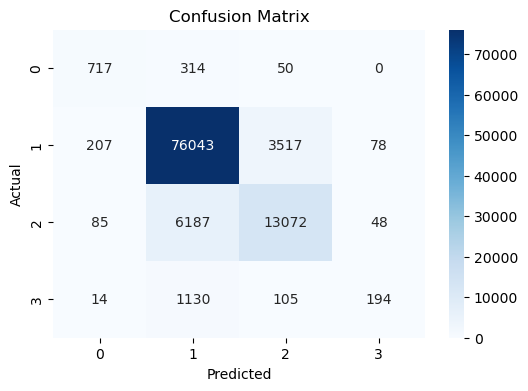

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.66      0.68      1081
           1       0.91      0.95      0.93     79845
           2       0.78      0.67      0.72     19392
           3       0.61      0.13      0.22      1443

    accuracy                           0.88    101761
   macro avg       0.75      0.61      0.64    101761
weighted avg       0.88      0.88      0.88    101761



In [ ]:
report(y_test,y_pred_ada)

## XGBoost

In [ ]:
# Get the parameters of the trained model
params = xgb_best.get_params()

# Print the parameters
print(params)

{'objective': 'multi:softprob', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.7, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'mlogloss', 'feature_types': None, 'gamma': 0.1, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.05, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 9, 'max_leaves': None, 'min_child_weight': 10, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 1000, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.9, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [ ]:
xgb_params_best = {'objective': 'multi:softprob', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.7, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'mlogloss', 'feature_types': None, 'gamma': 0.1, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.05, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 9, 'max_leaves': None, 'min_child_weight': 10, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 1000, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.9, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
xgb_best = XGBClassifier(**xgb_params_best)

In [ ]:
xgb_best = XGBClassifier(
    objective='multi:softprob',
    base_score=None,
    booster=None,
    colsample_bytree=0.8,
    gamma=0.2,
    learning_rate=0.3,
    max_depth=12,
    min_child_weight=2,
    missing=np.nan,  # This uses numpy's representation of NaN
    n_estimators=150,
    subsample=0.8,
    eval_metric='mlogloss',
    enable_categorical=False
)

In [ ]:
xgb_classifier = xgb_best
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
              max_leaves=None, min_child_weight=10, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
y_pred_xgb = xgb_classifier.predict(X_test)
Eval_xgb=classification_task(xgb_classifier,X_train, y_train ,X_test,y_test, y_pred_xgb,'XGBoost')
Eval_xgb

,Train_Score,Test_Score,Precision_Score,Recall_Score,F1_Score,accuracy
XGBoost,0.97209,0.905131,0.899759,0.905131,0.900261,0.905131


Accuracy: 0.91


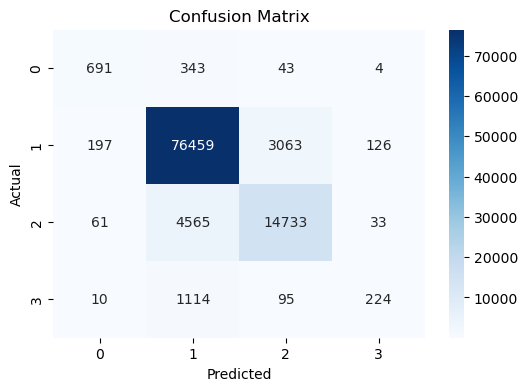

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.64      0.68      1081
           1       0.93      0.96      0.94     79845
           2       0.82      0.76      0.79     19392
           3       0.58      0.16      0.24      1443

    accuracy                           0.91    101761
   macro avg       0.76      0.63      0.66    101761
weighted avg       0.90      0.91      0.90    101761



In [ ]:
report(y_test,y_pred_xgb)

## LightGBM

In [ ]:
# Get the parameters of the trained model
params = lgb_best.get_params()

# Print the parameters
print(params)

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.6, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 15, 'min_child_samples': 200, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': None, 'num_leaves': 33, 'objective': 'multiclass', 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 0.7, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbosity': 0}


In [ ]:
lgb_params_best = {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.6, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 15, 'min_child_samples': 200, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': None, 'num_leaves': 33, 'objective': 'multiclass', 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 0.7, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbosity': 0}
lgb_best = LGBMClassifier(**lgb_params_best)


In [ ]:
lgb_best = LGBMClassifier(
    boosting_type='gbdt',  # Gradient Boosting Decision Tree
    class_weight=None,
    colsample_bytree=1.0,
    importance_type='split',
    learning_rate=0.1,
    max_depth=10,
    min_child_samples=20,
    min_child_weight=0.001,
    min_split_gain=0.0,
    n_estimators=200,
    n_jobs=None,  # Use the default value; in most cases, it's set to use all processors
    num_leaves=50,
    objective='multiclass',
    random_state=42,
    reg_alpha=0.0,
    reg_lambda=0.0,
    subsample=1.0,
    subsample_for_bin=200000,
    subsample_freq=0,
    verbosity=0  # Controls the level of LightGBM's verbosity (0 - silent)
)

In [ ]:
lgb_classifier = lgb_best
lgb_classifier.fit(X_train, y_train)

LGBMClassifier(colsample_bytree=0.6, max_depth=15, min_child_samples=200,
               n_estimators=500, num_leaves=33, objective='multiclass',
               random_state=42, subsample=0.7, verbosity=0)

In [ ]:
y_pred_lgb = lgb_classifier.predict(X_test)
Eval_lgb=classification_task(lgb_classifier,X_train, y_train ,X_test,y_test, y_pred_lgb,'LGB')
Eval_lgb

,Train_Score,Test_Score,Precision_Score,Recall_Score,F1_Score,accuracy
LGB,0.93248,0.9006,0.894713,0.9006,0.895368,0.9006


Accuracy: 0.90


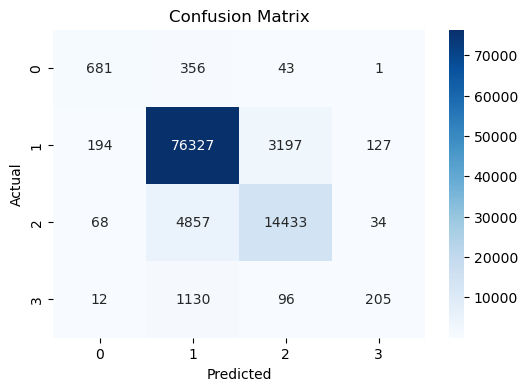

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.63      0.67      1081
           1       0.92      0.96      0.94     79845
           2       0.81      0.74      0.78     19392
           3       0.56      0.14      0.23      1443

    accuracy                           0.90    101761
   macro avg       0.75      0.62      0.65    101761
weighted avg       0.89      0.90      0.90    101761



In [ ]:
report(y_test,y_pred_lgb)

## CatBoost

In [ ]:
# Get the parameters of the trained model
params = cb_best.get_params()

# Print the parameters
print(params)

{'loss_function': 'MultiClass', 'verbose': 0, 'eval_metric': 'Accuracy', 'learning_rate': 0.2, 'l2_leaf_reg': 5, 'iterations': 710, 'depth': 9, 'ctr_target_border_count': 200, 'border_count': 200}


In [ ]:
cb_params_best = {'loss_function': 'MultiClass', 'verbose': 0, 'eval_metric': 'Accuracy', 'learning_rate': 0.2, 'l2_leaf_reg': 5, 'iterations': 700, 'depth': 9, 'ctr_target_border_count': 200, 'border_count': 200}
cb_best = CatBoostClassifier(**cb_params_best)

In [ ]:
cb_best = CatBoostClassifier(
    loss_function='MultiClass',  # Specifies multiclass classification
    verbose=0,  # Controls the verbosity: 0 means silent
    eval_metric='Accuracy',  # Metric used for evaluation during training
    learning_rate=0.2,  # The learning rate
    l2_leaf_reg=5,  # L2 regularization term on weights, it's also called lambda
    iterations=1000,  # The maximum number of trees that can be built
    depth=9  # Depth of the tree
)

In [ ]:
cb_classifier = cb_best
cb_classifier.fit(X_train, y_train)

In [ ]:
y_pred_cb = cb_classifier.predict(X_test)
Eval_cb=classification_task(cb_classifier,X_train, y_train ,X_test,y_test, y_pred_cb,'CatBoost')
Eval_cb

,Train_Score,Test_Score,Precision_Score,Recall_Score,F1_Score,accuracy
CatBoost,0.946471,0.897996,0.891889,0.897996,0.892529,0.897996


Accuracy: 0.90


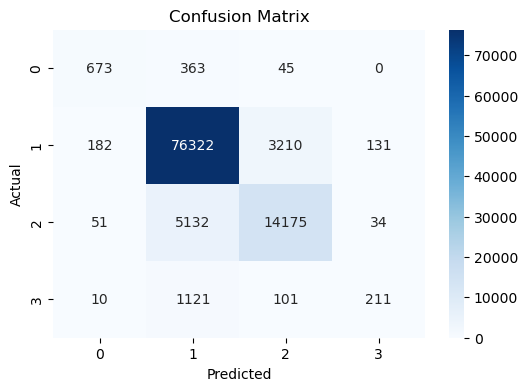

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.62      0.67      1081
           1       0.92      0.96      0.94     79845
           2       0.81      0.73      0.77     19392
           3       0.56      0.15      0.23      1443

    accuracy                           0.90    101761
   macro avg       0.76      0.61      0.65    101761
weighted avg       0.89      0.90      0.89    101761



In [ ]:
report(y_test,y_pred_cb)

## Bagging Classifier


In [ ]:
bc_params_best = {
    'bootstrap': False,
    'bootstrap_features': False,
    'max_features': 0.9,
    'max_samples': 0.9,
    'n_estimators': 100,
    'n_jobs': None,
    'oob_score': False,
    'random_state': None,
    'verbose': 0,
    'warm_start': False
}
bc_best = BaggingClassifier(**bc_params_best)

In [ ]:
bc_classifier = bc_best
bc_classifier.fit(X_train, y_train)

BaggingClassifier(bootstrap=False, max_features=0.9, max_samples=0.9,
                  n_estimators=100)

In [ ]:
y_pred_bc = bc_classifier.predict(X_test)
Eval_bc=classification_task(bc_classifier,X_train, y_train ,X_test,y_test, y_pred_bc,'Bagging')
Eval_bc

,Train_Score,Test_Score,Precision_Score,Recall_Score,F1_Score,accuracy
Bagging,0.999798,0.904492,0.89832,0.904492,0.899356,0.904492


Accuracy: 0.90


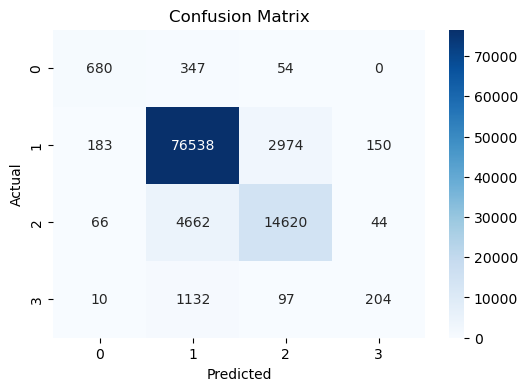

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.63      0.67      1081
           1       0.93      0.96      0.94     79845
           2       0.82      0.75      0.79     19392
           3       0.51      0.14      0.22      1443

    accuracy                           0.90    101761
   macro avg       0.75      0.62      0.66    101761
weighted avg       0.90      0.90      0.90    101761



In [ ]:
report(y_test,y_pred_bc)

## Random Forest

In [ ]:

rf_params_best = {'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 22, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 9, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
rf_best = RandomForestClassifier(**rf_params_best)

In [ ]:
rf_classifier = rf_best
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=22, max_features='log2',
                       min_samples_leaf=5, min_samples_split=9)

In [ ]:
y_pred_rf = rf_classifier.predict(X_test)
Eval_rf=classification_task(rf_classifier,X_train, y_train ,X_test,y_test, y_pred_rf,'Random Forest')
Eval_rf

,Train_Score,Test_Score,Precision_Score,Recall_Score,F1_Score,accuracy
Random Forest,0.960845,0.891825,0.886626,0.891825,0.882417,0.891825


Accuracy: 0.89


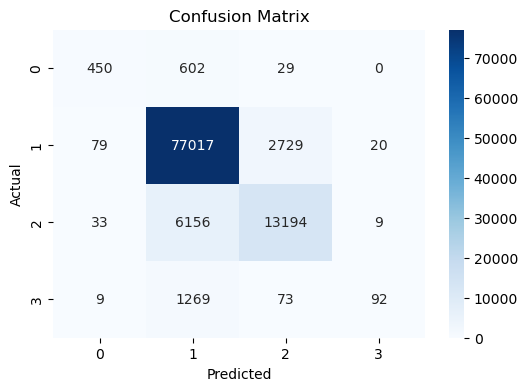

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.42      0.54      1081
           1       0.91      0.96      0.93     79845
           2       0.82      0.68      0.75     19392
           3       0.76      0.06      0.12      1443

    accuracy                           0.89    101761
   macro avg       0.82      0.53      0.59    101761
weighted avg       0.89      0.89      0.88    101761



In [ ]:
report(y_test,y_pred_rf)

## Extra Trees

In [ ]:

et_params_best = {'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 19, 'max_features': 0.75, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 15, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 910, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
et_best = ExtraTreesClassifier(**et_params_best)

In [ ]:
et_classifier = et_best
et_classifier.fit(X_train, y_train)

ExtraTreesClassifier(max_depth=19, max_features=0.75, min_samples_leaf=15,
                     min_samples_split=3, n_estimators=910)

In [ ]:
y_pred_et = et_classifier.predict(X_test)
Eval_et=classification_task(et_classifier,X_train, y_train ,X_test,y_test, y_pred_et,'Extra Trees')
Eval_et

,Train_Score,Test_Score,Precision_Score,Recall_Score,F1_Score,accuracy
Extra Trees,0.903698,0.886007,0.880434,0.886007,0.876233,0.886007


Accuracy: 0.89


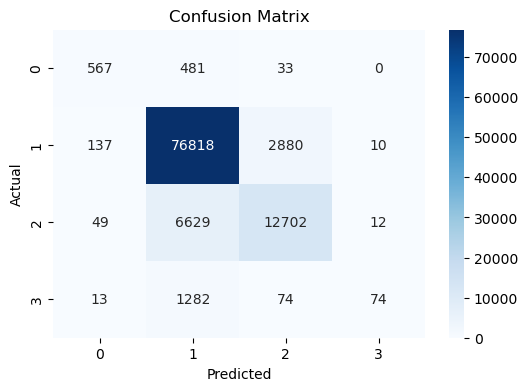

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.52      0.61      1081
           1       0.90      0.96      0.93     79845
           2       0.81      0.66      0.72     19392
           3       0.77      0.05      0.10      1443

    accuracy                           0.89    101761
   macro avg       0.81      0.55      0.59    101761
weighted avg       0.88      0.89      0.88    101761



In [ ]:
report(y_test,y_pred_et)

## Imbalanced Learning

In [ ]:
spe_best = SelfPacedEnsembleClassifier(estimator=DecisionTreeClassifier(), n_estimators=100, k_bins=10,
                 replacement=True, soft_resample_flag=True, random_state=None, verbose=0)

In [ ]:
spe_classifier =  spe_best
spe_classifier.fit(X_train, y_train)

SelfPacedEnsembleClassifier(estimator=DecisionTreeClassifier(), k_bins=10,
                            n_estimators=100,
                            random_state=RandomState(MT19937) at 0x104EB6E40,
                            soft_resample_flag=True)

In [ ]:
y_pred_spe = spe_classifier.predict(X_test)
Eval_spe=classification_task(spe_classifier,X_train, y_train ,X_test,y_test, y_pred_spe,'SPEBoost')
Eval_spe

,Train_Score,Test_Score,Precision_Score,Recall_Score,F1_Score,accuracy
SPEBoost,0.720415,0.70585,0.86779,0.70585,0.746949,0.70585


Accuracy: 0.71


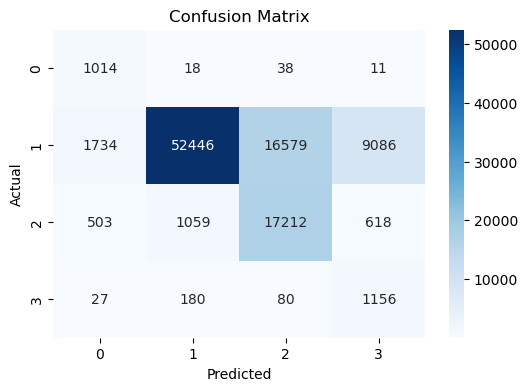

Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.94      0.47      1081
           1       0.98      0.66      0.79     79845
           2       0.51      0.89      0.65     19392
           3       0.11      0.80      0.19      1443

    accuracy                           0.71    101761
   macro avg       0.47      0.82      0.52    101761
weighted avg       0.87      0.71      0.75    101761



In [ ]:
report(y_test,y_pred_spe)

In [ ]:
bbc_best = BalancedBaggingClassifier(estimator=DecisionTreeClassifier(max_depth=15), n_estimators=100, random_state=42)
bbc_classifier = bbc_best
bbc_classifier.fit(X_train, y_train)

BalancedBaggingClassifier(estimator=DecisionTreeClassifier(max_depth=15),
                          n_estimators=100, random_state=42)

In [ ]:
y_pred_bbc = bbc_classifier.predict(X_test)
Eval_bbc=classification_task(bbc_classifier,X_train, y_train ,X_test,y_test, y_pred_brf,'Balanced Bagging Classifier')
Eval_bbc

,Train_Score,Test_Score,Precision_Score,Recall_Score,F1_Score,accuracy
Balanced Bagging Classifier,0.733753,0.724325,0.86766,0.711333,0.758015,0.711333


Accuracy: 0.72


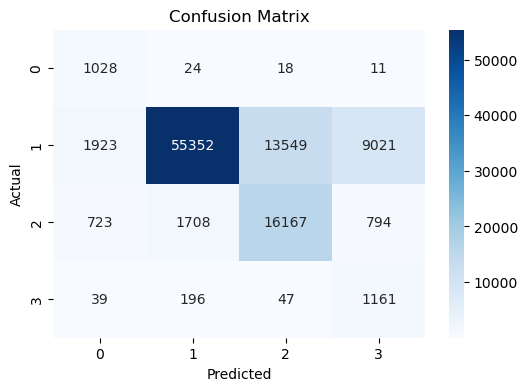

Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.95      0.43      1081
           1       0.97      0.69      0.81     79845
           2       0.54      0.83      0.66     19392
           3       0.11      0.80      0.19      1443

    accuracy                           0.72    101761
   macro avg       0.47      0.82      0.52    101761
weighted avg       0.87      0.72      0.77    101761



In [ ]:
report(y_test,y_pred_bbc)

## Voting

In [ ]:
vt_classifier = VotingClassifier(estimators=[
    ('bc',bc_best),
    ('lgb',lgb_best),
    ('xgb', xgb_best),
    ('spe', spe_best),
    ('bbc', BalancedBaggingClassifier(estimator=DecisionTreeClassifier(max_depth=15), n_estimators=100, random_state=42)),

], voting='soft')
vt_classifier.fit(X_train, y_train)

VotingClassifier(estimators=[('bc',
                              BaggingClassifier(bootstrap=False,
                                                max_features=0.9,
                                                max_samples=0.9,
                                                n_estimators=100)),
                             ('lgb',
                              LGBMClassifier(colsample_bytree=0.6, max_depth=15,
                                             min_child_samples=200,
                                             n_estimators=500, num_leaves=33,
                                             objective='multiclass',
                                             random_state=42, subsample=0.7,
                                             verbosity=0)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            cal...
                                            multi_strategy=None,
                                            n_estimators=1000, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='multi:softprob', ...)),
                             ('spe',
                              SelfPacedEnsembleClassifier(estimator=DecisionTreeClassifier(),
                                                          k_bins=10,
                                                          n_estimators=100,
                                                          soft_resample_flag=True)),
                             ('bbc',
                              BalancedBaggingClassifier(estimator=DecisionTreeClassifier(max_depth=15),
                                                        n_estimators=100,
                                                        random_state=42))],
                 voting='soft')

In [ ]:
y_pred_vt = vt_classifier.predict(X_test)
Eval_vt=classification_task(vt_classifier,X_train, y_train ,X_test,y_test, y_pred_vt,'Voting')
Eval_vt

,Train_Score,Test_Score,Precision_Score,Recall_Score,F1_Score,accuracy
Voting,0.974613,0.900699,0.901785,0.900699,0.90093,0.900699


Accuracy: 0.90


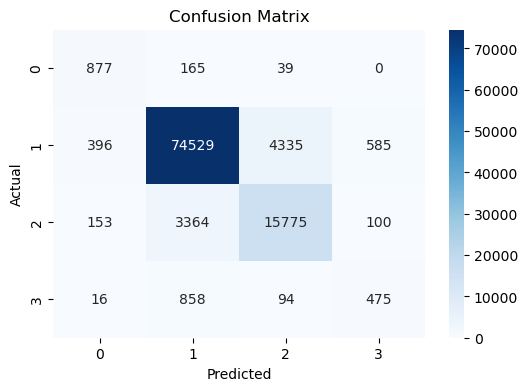

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.81      0.70      1081
           1       0.94      0.93      0.94     79845
           2       0.78      0.81      0.80     19392
           3       0.41      0.33      0.36      1443

    accuracy                           0.90    101761
   macro avg       0.69      0.72      0.70    101761
weighted avg       0.90      0.90      0.90    101761



In [ ]:
report(y_test,y_pred_vt)

In [ ]:
RUSBoostClassifier(n_estimators=100, estimator=DecisionTreeClassifier(max_depth=15), random_state=42)
EasyEnsembleClassifier(n_estimators=100, estimator=DecisionTreeClassifier(max_depth=15), random_state=42)
BalancedBaggingClassifier(estimator=DecisionTreeClassifier(max_depth=15), n_estimators=100, random_state=42)
BalanceCascadeClassifier(estimator=DecisionTreeClassifier(max_depth=15),random_state=42)
BalancedRandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)
SPEnsembleClassifier(estimator=DecisionTreeClassifier(max_depth=15), n_estimators=100, random_state=42)

Accuracy: 0.71


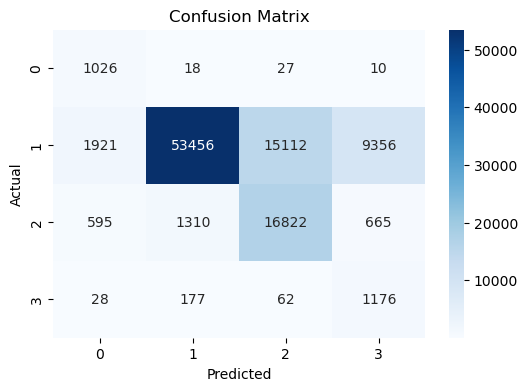

Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.95      0.44      1081
           1       0.97      0.67      0.79     79845
           2       0.53      0.87      0.65     19392
           3       0.10      0.81      0.19      1443

    accuracy                           0.71    101761
   macro avg       0.47      0.83      0.52    101761
weighted avg       0.87      0.71      0.75    101761



In [ ]:
brf_best = SelfPacedEnsembleClassifier(estimator=DecisionTreeClassifier(max_depth=15), n_estimators=100, random_state=42)
brf_classifier = brf_best
brf_classifier.fit(X_train, y_train)
y_pred_brf = brf_classifier.predict(X_test)
Eval_brf=classification_task(brf_classifier,X_train, y_train ,X_test,y_test, y_pred_brf,'Balanced Random Forest')
Eval_brf
report(y_test,y_pred_brf)